<a href="https://colab.research.google.com/github/Sruthij93/Market-Anomaly-Detection/blob/main/Market_Anomaly_Milestone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pickle
import shap
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [4]:
!git clone https://github.com/Sruthij93/Market-Anomaly-Detection

Cloning into 'Market-Anomaly-Detection'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 94 (delta 46), reused 47 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (94/94), 10.47 MiB | 11.01 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [5]:
%cd /content/Market-Anomaly-Detection

/content/Market-Anomaly-Detection


In [6]:
sim_data = pd.read_csv('/content/Market-Anomaly-Detection/sim_financial_data.csv')

In [15]:
sim_data.shape

(1097, 15)

In [7]:
# Clean the test data and conduct preprocessing

def data_cleaning(test_df):

  model_features = ['XAU BGNL', 'BDIY', 'CRY', 'DXY', 'VIX', 'USGG30YR', 'GT10', 'EONIA', 'GTITL30YR', 'GTJPY30YR', 'LP01TREU', 'MXUS', 'MXEU', 'MXIN']
  # 'GC=F', ^VIX, ^TYX, ^XDE,

  # Drop any extra columns not in the model features
  test_df = test_df.loc[:, test_df.columns.intersection(model_features)]


  # Add missing columns with default value
  missing_columns = [col for col in model_features if col not in test_df.columns]

  for col in missing_columns:
      test_df[col] = 0

  # Reorder columns to match model's feature order
  test_df = test_df[model_features]

  # Remove the date column
  if 'Date' in test_df.columns:
    test_df = test_df.drop(columns = ['Date'])

  # Add additional columns of moving averages and simple moving averages
  test_df['VIX_EMA'] = test_df['VIX'].ewm(span=50, adjust=False).mean()
  test_df['BDIY_EMA'] = test_df['BDIY'].ewm(span=50, adjust=False).mean()
  test_df['DXY_EMA'] = test_df['DXY'].ewm(span=50, adjust=False).mean()
  test_df['VIX_MA'] = test_df['VIX'].rolling(window=50).mean()
  test_df['BDIY_MA'] = test_df['BDIY'].rolling(window=50).mean()

  test_df['VIX_MA'] = test_df['VIX_MA'].fillna(test_df['VIX'])
  test_df['BDIY_MA'] = test_df['BDIY_MA'].fillna(test_df['BDIY'])

  return test_df


def data_preprocessing(test_df, model):

  test_df = data_cleaning(test_df)

  # Load the scaler saved in pickle file
  with open('/content/Market-Anomaly-Detection/scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

  # Scale the data
  test_df_scaled = scaler.fit_transform(test_df)

  if model == 'isolation_forest':
    # Load the PCA saved in pickle file
    with open('/content/Market-Anomaly-Detection/pca_isoforest.pkl', 'rb') as file:
      pca = pickle.load(file)
  else:
    # Load PCA
    with open('/content/Market-Anomaly-Detection/pca.pkl', 'rb') as file:
      pca = pickle.load(file)

  # Apply PCA
  test_df_pca = pca.transform(test_df_scaled)

  # Adding raw features(scaled) for better performance
  test_df_columns = {name: index for index, name in enumerate(test_df.columns)}
  selected_columns = ['VIX', 'VIX_EMA', 'BDIY_EMA', 'DXY_EMA', 'VIX_MA', 'BDIY_MA']
  selected_columns_indices = [test_df_columns[col] for col in selected_columns]

  test_set = np.hstack((test_df_pca, test_df_scaled[:, selected_columns_indices]))

  return test_set




In [10]:
# Test the Isolation Forest model
# sim_data = sim_data.to_frame().T
test_df = data_preprocessing(sim_data, 'isolation_forest')

with open('/content/Market-Anomaly-Detection/isoforest_model.pkl', 'rb') as file:
  isoforest_model = pickle.load(file)

isoforest_predictions = isoforest_model.predict(test_df)

# Print the anomaly score for each row and add anomaly label column to a copy of test_df
isoforest_scores = isoforest_model.score_samples(test_df)
data_copy = sim_data.copy()
data_copy['isoforest_predictions'] = isoforest_scores
data_copy['Anomaly_ISO'] = isoforest_predictions > 0
data_copy['Anomaly_ISO'] = data_copy['Anomaly_ISO'].astype(int)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ExtraTreeRegressor from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid

In [17]:
data_copy.shape

(1097, 17)

In [12]:
data_copy['Anomaly_ISO'].value_counts()

,count
Anomaly_ISO,
1,616
0,481


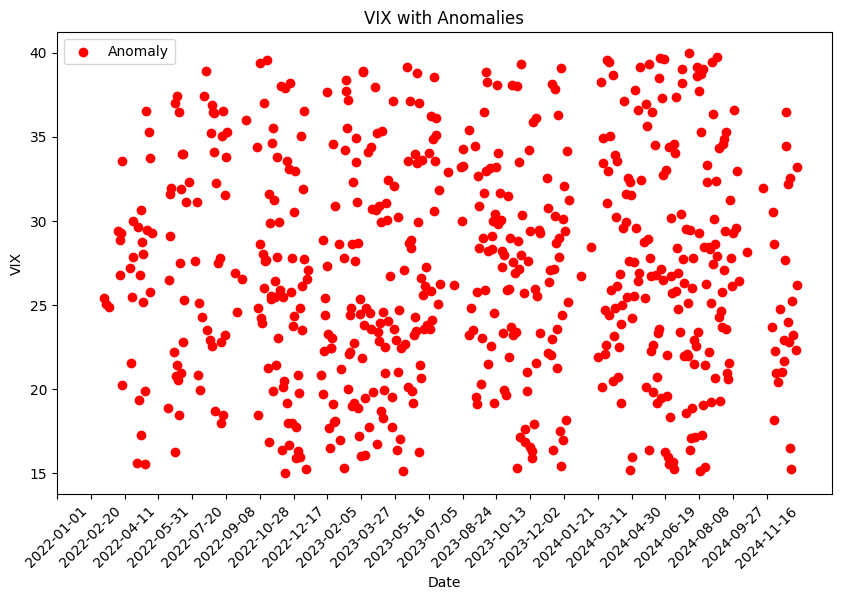

In [14]:
# plot the anomalies along VIX
plt.figure(figsize=(10, 6))
plt.scatter(data_copy[data_copy['Anomaly_ISO'] == 1].index, data_copy[data_copy['Anomaly_ISO'] == 1]['VIX'], color='red', label='Anomaly')
plt.xticks(range(0, data_copy.shape[0], 50), data_copy['Date'].iloc[::50], rotation = 45)
plt.xlabel('Date')
plt.ylabel('VIX')
plt.title('VIX with Anomalies')
plt.legend()
plt.show()

In [12]:
# Test the SVM model
with open('/content/Market-Anomaly-Detection/svm_model.pkl', 'rb') as file:
  svm_model = pickle.load(file)

test_df = data_preprocessing(sim_data, 'svm')
svm_predictions = svm_model.predict(test_df)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use a

In [16]:
# Test the Voting classifier model
with open('/content/Market-Anomaly-Detection/voting_clf_model.pkl', 'rb') as file:
  voting_clf = pickle.load(file)

test_df = data_preprocessing(sim_data, 'voting')
voting_predictions = voting_clf.predict(test_df)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.2 when using version 1.6.0. This might lead to breaking cod

In [14]:
voting_predictions= voting_predictions.reshape(-1,1)

## Strategies
- Buy options when VIX is low and sell options when VIX is high
- If the DXY indicates an uptrend in value, it is best to buy the USD against other currencies. If the USD is going through a downtrend, it is time to sell the USD against another, stronger currency.
- During an anomaly:
  - Market Crash:
    * Shift to safe-haven markets like gold, US Treasury bonds, or defensive stocks (utilities, healthcare)
    * Avoid panic selling- hold quality stocks if you believe in their long term potential
  - Volatality Spike (high VIX)
    * sell options if you are experienced, as high volality inflates their premiums
    * Conservative: reduce equity exposure and increase cash or bonds
    * dont buy volatile stocks, as prices swing wildly.
  - Currency Anomalies (USD spike or crash)
    * USD Uptrend: invest in USD denominated assets or exporting companies
    * USD Downtrend: explore assets like gold or foreign stocks that could benefit from a weaker dollar
- During calm markets or no anomalies:
  - Diversify Portfolio
  - Use Dollar Cost Averaging (DCA) eg: invest $500 monthly in S&P 500 index fund
  - Rebalance your Portfolio:
    * if stocks outperform bonds, rebalance by selling some stocks and buying more bonds
  - Invest in Growth Opportunities


## Next Steps
- create a strategy column for the test data
- check if it matches the anomaly indicator
- Feed in the results - test data, with predictions to an LLM and ask it to verify


In [81]:
# JSON Object with all the strategies as context to feed into an LLM

strategies = {
  "investment_rules": [
    {
      "feature": "XAU_BGNL",
      "description": "Gold Prices",
      "signals": [
        {
          "condition": "VIX > 25 OR DXY < 90",
          "action": "Increase exposure to gold as a safe-haven asset."
        },
        {
          "condition": "DXY > 100 AND USGG30YR > 3%",
          "action": "Reduce exposure to gold due to rising dollar strength and interest rates."
        }
      ]
    },
    {
      "feature": "BDIY",
      "description": "Baltic Dry Index (Global Trade Health)",
      "signals": [
        {
          "condition": "BDIY trending upwards",
          "action": "Invest in cyclical sectors (e.g., industrials, energy, commodities)."
        },
        {
          "condition": "BDIY consistently declining",
          "action": "Reduce exposure to cyclical stocks; consider defensive assets."
        }
      ]
    },
    {
      "feature": "CRY",
      "description": "Core Commodity CRB Excess Return Index",
      "signals": [
        {
          "condition": "CRY trending upwards",
          "action": "Invest in commodity-focused ETFs or inflation-hedging assets like energy and agriculture."
        },
        {
          "condition": "CRY trending downwards",
          "action": "Shift investments to defensive sectors or government bonds."
        }
      ]
    },
    {
      "feature": "DXY",
      "description": "US Dollar Index",
      "signals": [
        {
          "condition": "DXY weakening",
          "action": "Invest in international equities (e.g., MXEU, MXIN) or commodities like gold and oil."
        },
        {
          "condition": "DXY strengthening",
          "action": "Reduce exposure to emerging market equities and commodities, which may underperform."
        }
      ]
    },
    {
      "feature": "VIX",
      "description": "Volatility Index (Fear Index)",
      "signals": [
        {
          "condition": "VIX is low",
          "action": "Focus on growth-oriented stocks or riskier assets."
        },
        {
          "condition": "VIX is spiking and anomalies are detected",
          "action": "Reduce risk by increasing allocations to bonds or cash."
        }
      ]
    },
    {
      "feature": "USGG30YR",
      "description": "US 30-Year Government Bonds",
      "signals": [
        {
          "condition": "USGG30YR yields falling",
          "action": "Increase allocation to growth stocks and bonds as lower yields are favorable."
        },
        {
          "condition": "USGG30YR yields rising",
          "action": "Shift to inflation-protected assets or shorter-duration bonds to minimize risk."
        }
      ]
    },
    {
      "feature": "GT10",
      "description": "US 10-Year Treasury Yield",
      "signals": [
        {
          "condition": "GT10 yields falling",
          "action": "Invest in long-term bonds and growth-oriented stocks."
        },
        {
          "condition": "GT10 yields rising",
          "action": "Shift to value stocks or shorter-duration bonds to hedge against interest rate risk."
        }
      ]
    },
    {
      "feature": "EONIA",
      "description": "Euro Overnight Index Average",
      "signals": [
        {
          "condition": "EONIA falling",
          "action": "Invest in European equities or longer-duration bonds due to dovish ECB policy."
        },
        {
          "condition": "EONIA rising",
          "action": "Reduce exposure to equities and longer-duration bonds in the Eurozone."
        }
      ]
    },
    {
      "feature": "GTITL30YR",
      "description": "Italian Government 30-Year Bonds",
      "signals": [
        {
          "condition": "GTITL30YR yields falling",
          "action": "Increase allocation to safe-haven assets like gold or high-grade bonds."
        },
        {
          "condition": "GTITL30YR yields rising",
          "action": "Consider investing in equities or risk-on assets, indicating improving economic conditions."
        }
      ]
    },
    {
      "feature": "GTJPY30YR",
      "description": "Japanese Government 30-Year Bonds",
      "signals": [
        {
          "condition": "GTJPY30YR yields falling",
          "action": "Shift to safe-haven assets like gold or government bonds in stable economies."
        },
        {
          "condition": "GTJPY30YR yields rising",
          "action": "Consider equities or risk-on assets, indicating potential growth."
        }
      ]
    },
    {
      "feature": "LP01TREU",
      "description": "Pan Euro High Yield Index",
      "signals": [
        {
          "condition": "LP01TREU rising",
          "action": "Invest in European equities and high-yield bonds, signaling improved credit conditions."
        },
        {
          "condition": "LP01TREU falling",
          "action": "Reduce exposure to high-yield bonds and riskier European assets due to tighter credit."
        }
      ]
    },
    {
      "feature": "MXUS",
      "description": "US Equity Index",
      "signals": [
        {
          "condition": "MXUS trending upwards",
          "action": "Increase exposure to US equities for potential growth opportunities."
        },
        {
          "condition": "MXUS trending downwards",
          "action": "Reduce exposure to US equities; consider defensive assets."
        }
      ]
    },
    {
      "feature": "MXEU",
      "description": "European Equity Index",
      "signals": [
        {
          "condition": "MXEU trending upwards",
          "action": "Increase exposure to European equities for potential growth opportunities."
        },
        {
          "condition": "MXEU trending downwards",
          "action": "Reduce exposure to European equities; consider safer assets like bonds."
        }
      ]
    },
    {
      "feature": "MXIN",
      "description": "Indian Equity Index",
      "signals": [
        {
          "condition": "MXIN trending upwards",
          "action": "Increase exposure to Indian equities for emerging market growth."
        },
        {
          "condition": "MXIN trending downwards",
          "action": "Reduce exposure to Indian equities; shift to safer or developed market assets."
        }
      ]
    }
  ]
}


In [82]:
type(strategies)

dict

In [77]:
data

,Date,XAU BGNL,BDIY,CRY,DXY,VIX,USGG30YR,GT10,EONIA,GTITL30YR,GTJPY30YR,LP01TREU,MXUS,MXEU,MXIN,isoforest_predictions,Anomaly_ISO
1077,2024-12-13,1903.894185,1454.359114,200.997878,93.267335,27.648145,1.959532,2.605695,-0.269505,2.721885,0.171523,149.162072,4112.272758,466.529512,640.894507,-0.450683,1
1078,2024-12-14,1765.476166,2674.082250,272.344366,93.689181,34.443198,2.942340,1.095904,-0.172434,3.589086,0.771546,140.423014,4726.740565,455.386652,522.981085,-0.471299,1
1079,2024-12-15,1984.988355,1558.552177,253.565660,94.045879,36.458073,1.887103,2.553661,-0.290107,2.444148,0.223413,107.997040,4944.332236,330.010085,711.772001,-0.480356,1
1080,2024-12-16,1935.903504,2285.763820,283.611770,97.734141,36.121602,2.390485,2.944694,-0.008124,1.235582,0.080847,113.888202,4610.748495,427.602165,618.099024,-0.496852,0
1081,2024-12-17,1726.823301,2388.301147,282.138836,91.023004,23.991889,3.242533,2.250896,-0.480389,2.681618,0.874933,116.490790,4715.850016,229.273751,581.800397,-0.461173,1
1082,2024-12-18,1825.274233,2025.309506,284.332617,97.955869,32.180859,2.900290,1.893783,0.171368,1.996222,0.858751,132.518278,4761.969745,212.073431,501.013654,-0.458711,1
1083,2024-12-19,1963.735492,1610.621353,248.509466,100.234149,22.820855,2.466156,1.693567,0.023158,1.464825,0.403570,137.849738,4262.814275,425.970924,715.949094,-0.475731,1
1084,2024-12-20,1983.419607,1425.288753,233.362840,99.665886,16.522639,2.550624,2.607005,0.398639,3.547104,0.702396,137.476330,4045.229631,327.606582,750.142793,-0.480920,1
1085,2024-12-21,1840.220453,1066.378709,279.155820,97.655682,32.539132,2.905277,2.732003,-0.335607,2.564799,0.557066,125.493703,4001.872744,498.664779,618.512161,-0.479048,1
1086,2024-12-22,1884.023417,1607.892802,245.129411,106.782932,15.245689,1.514662,3.177419,0.304109,3.799829,0.852956,140.541027,4350.649283,229.176265,669.265393,-0.477892,1


In [78]:
# get the last 20 rows from data_copy to feed into LLM
data = data_copy.tail(20)

data_llm = []
# preprocess each row in data make it into a string
for index, row in data.iterrows():
  data_llm.append([f"{row['Date']} had the these market values: XAU BGNL: {row['XAU BGNL']:.3f}, BDIY: {row['BDIY']:.3f}, CRY: {row['CRY']:.3f}, DXY: {row['DXY']:.3f}, VIX: {row['VIX']:.3f}, USGG30YR: {row['USGG30YR']:.3f}, GT10: {row['GT10']:.3f}, EONIA: {row['EONIA']:.3f}, GTITL30YR: {row['GTITL30YR']:.3f}, GTJPY30YR: {row['GTJPY30YR']:.3f}, LP01TREU: {row['LP01TREU']:.3f}, MXUS: {row['MXUS']:.3f}, MXEU: {row['MXEU']:.3f}, MXIN: {row['MXIN']:.3f}, Anomaly: {row['Anomaly_ISO']}"])

llm_data = '\n'.join(data_llm[row][0] for row in range(len(data_llm)))




In [19]:
from google.colab import userdata

In [20]:
import os
import google.generativeai as genai

genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

In [88]:
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 40,
  "max_output_tokens": 8192,
  "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
  model_name="gemini-2.0-flash-exp",
  generation_config=generation_config,
)

prompt = f'''You are an expert in Stock markets and have deep knowledge of how to make financial investments.
        Your goal is analyze the {llm_data} and understand the market conditions.
        Identify any upward or downward trend for the market indicators.
        Do not pick out any specific indicators.
        Do not give day by day analysis.
        Provide only a summary of the whole period.
        Provide clear advice on what kind of decisions should be made.
        Follow this for more context : {strategies} but augment with this better decisions.
        '''

In [53]:
myTuple = [["John"], ["Peter"], ["Vicky"]]
string = '\n'.join(str(row[0]) for row in myTuple)
print(string)
print((myTuple[row] for row in myTuple))

John
Peter
Vicky
<generator object <genexpr> at 0x7fc2324925a0>


In [89]:
response = model.generate_content(prompt)


In [90]:
print(response.text)

Okay, let's analyze the market data provided and formulate a comprehensive investment strategy based on the observed trends and your investment rules.

**Market Summary (2024-12-13 to 2025-01-01):**

The provided period shows a volatile market environment characterized by significant swings in multiple indicators. There's no consistent upward or downward trend that applies to all indicators uniformly. Here’s a breakdown:

*   **Gold (XAU BGNL):** Gold prices show volatility, moving between peaks and troughs. It initially starts at a high, then declines before increasing again, ending the period on a lower value than at the start. This suggests that external factors are affecting gold more than internal trend. 
*   **Global Trade (BDIY):** The Baltic Dry Index demonstrates significant volatility, generally trending upwards. This implies there is high uncertainty in global trade and shipping rates.
*   **Commodities (CRY):** The Core Commodity CRB Excess Return Index, while also volatile